<a href="https://colab.research.google.com/github/Rama-vanapalli/MajorProject/blob/main/VGG16_Base_256.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense
from tensorflow.keras.layers import Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2

In [ ]:
from tensorflow.keras import backend as K

def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_val

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input
# Data Preparation

batch_size =256

datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    '/content/drive/MyDrive/Infection Segmentation Data/Infection Segmentation Data/Train',
    target_size=(256, 256),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    '/content/drive/MyDrive/Infection Segmentation Data/Infection Segmentation Data/Val',
    target_size=(256, 256),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)



Found 8972 images belonging to 3 classes.
Found 557 images belonging to 3 classes.


In [ ]:
# Assuming the rest of your code (above) has been executed...

# Retrieve the class indices
train_class_indices = train_generator.class_indices
validation_class_indices = validation_generator.class_indices

# Print the class indices for training and validation sets
print("Training class indices:", train_class_indices)
print("Validation class indices:", validation_class_indices)


Training class indices: {'COVID-19': 0, 'Non-COVID': 1, 'Normal': 2}
Validation class indices: {'COVID-19': 0, 'Non-COVID': 1, 'Normal': 2}


In [ ]:
from tensorflow.keras.applications import VGG16


# Directory where the checkpoints will be saved
checkpoint_dir = 'VGG16_Models/'
os.makedirs(checkpoint_dir, exist_ok=True)

# Define a ModelCheckpoint callback to save the model at every improved epoch
checkpoint = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, 'model_epoch_{epoch:02d}_train_acc_{accuracy:.4f}_val_acc_{val_accuracy:.4f}.h5'),
    monitor='val_accuracy', # metric to monitor
    verbose=1, # verbosity - 0 or 1
    save_best_only=True, # Save only the best model according to the monitored metric
    mode='max', # Since we are monitoring accuracy, higher is better
    save_weights_only=False # Save the full model, not just the weights
)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the base model
x = Flatten()(base_model.output)
x = Dense(32, activation='relu')(x)
x = Dense(16, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)  # Assuming 3 classes: normal, violence, and adultery

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy',f1_score])


history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=30,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[checkpoint],
    use_multiprocessing=True,  # <- Enable multiprocessing
    workers=8  # <- Number of workers to use. Adjust as per your CPU cores.
)





58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/30
36/36 [==============================] - ETA: 0s - loss: 2.8308 - accuracy: 0.6185 - f1_score: 0.6172
Epoch 1: val_accuracy improved from -inf to 0.68223, saving model to VGG16_Models/model_epoch_01_train_acc_0.6185_val_acc_0.6822.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


36/36 [==============================] - 391s 10s/step - loss: 2.8308 - accuracy: 0.6185 - f1_score: 0.6172 - val_loss: 1.9839 - val_accuracy: 0.6822 - val_f1_score: 0.6780
Epoch 2/30
36/36 [==============================] - ETA: 0s - loss: 0.7419 - accuracy: 0.7172 - f1_score: 0.7159
Epoch 2: val_accuracy improved from 0.68223 to 0.71275, saving model to VGG16_Models/model_epoch_02_train_acc_0.7172_val_acc_0.7127.h5
36/36 [==============================] - 108s 3s/step - loss: 0.7419 - accuracy: 0.7172 - f1_score: 0.7159 - val_loss: 2.1137 - val_accuracy: 0.7127 - val_f1_score: 0.7367
Epoch 3/30
36/36 [==============================] - ETA: 0s - loss: 0.5868 - accuracy: 0.7484 - f1_score: 0.7504
Epoch 3: val_accuracy improved from 0.71275 to 0.73968, saving model to VGG16_Models/model_epoch_03_train_acc_0.7484_val_acc_0.7397.h5
36/36 [==============================] - 114s 3s/step - loss: 0.5868 - accuracy: 0.7484 - f1_score: 0.7504 - val_loss: 1.8583 - val_accuracy: 0.7397 - val_f1_s

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [ ]:
# Assuming the rest of your code (above) has been executed...

# Retrieve the class indices
train_class_indices = train_generator.class_indices
validation_class_indices = validation_generator.class_indices

# Print the class indices for training and validation sets
print("Training class indices:", train_class_indices)
print("Validation class indices:", validation_class_indices)


Training class indices: {'COVID-19': 0, 'Non-COVID': 1, 'Normal': 2}
Validation class indices: {'COVID-19': 0, 'Non-COVID': 1, 'Normal': 2}


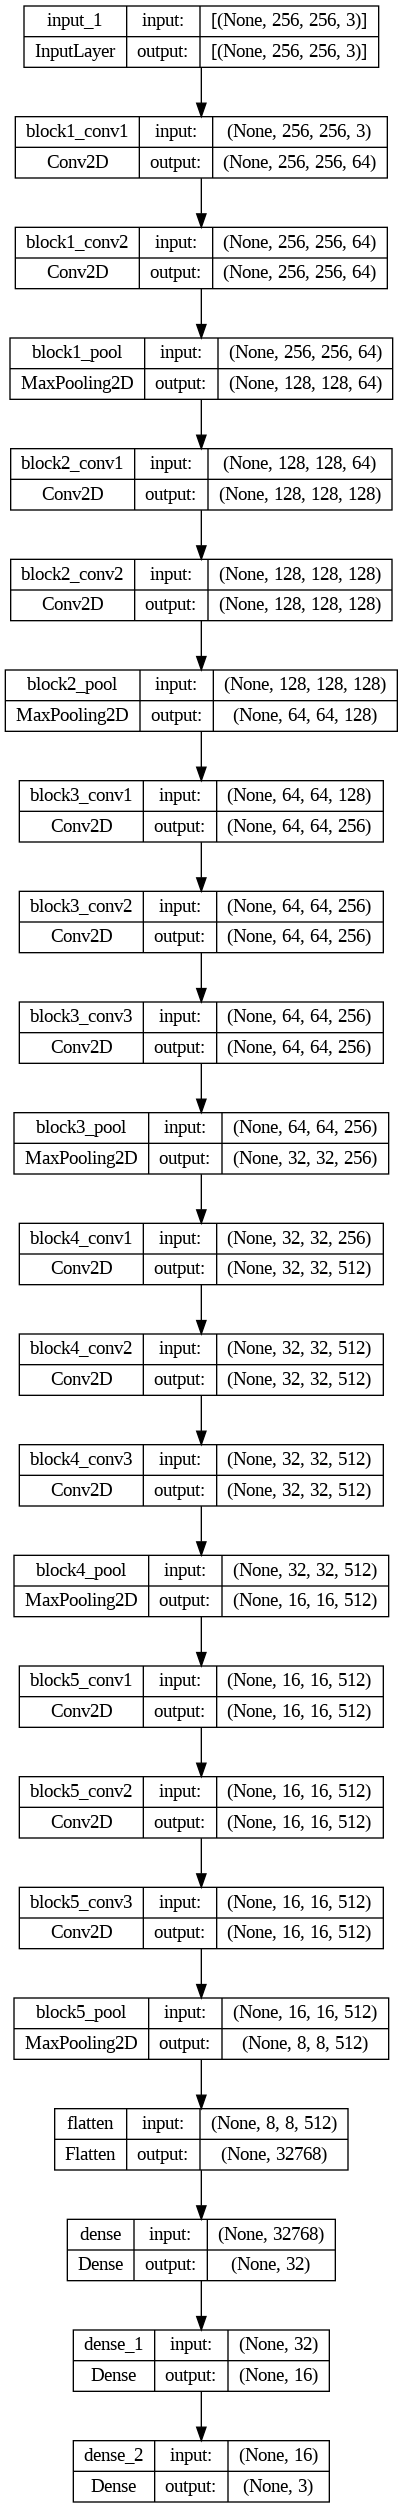

In [ ]:
from tensorflow.keras.utils import plot_model

# Plot the model
plot_model(model, to_file='vgg16_model.png', show_shapes=True, show_layer_names=True)


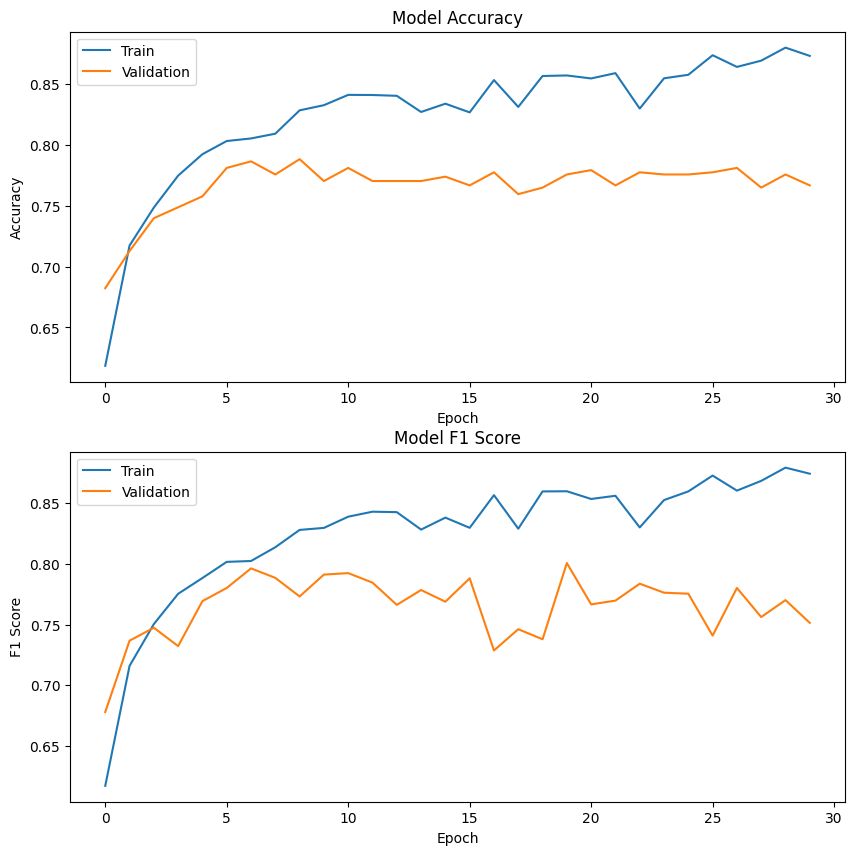

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'history' is the variable that holds the output of the fit function
# e.g., history = model.fit(...)

# Create subplots
fig, axs = plt.subplots(2, figsize=(10, 10))  # 2 rows, 1 column

# Plot training & validation accuracy values
axs[0].plot(history.history['accuracy'])
axs[0].plot(history.history['val_accuracy'])
axs[0].set_title('Model Accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation F1 score values
axs[1].plot(history.history['f1_score'])
axs[1].plot(history.history['val_f1_score'])
axs[1].set_title('Model F1 Score')
axs[1].set_ylabel('F1 Score')
axs[1].set_xlabel('Epoch')
axs[1].legend(['Train', 'Validation'], loc='upper left')


# Save the figure
plt.savefig('Vgg16_Graph.png')

# Close the figure to avoid displaying it in the notebook output
#plt.close()
